In [60]:
import pandas as pd
import acquire
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [92]:
canada, mexico = acquire.get_data()
mexico

,port_name,state,port_code,border,date,crossing_method,n_crossings
3,Brownsville,TX,2301,US-Mexico Border,2019-12-01,Bus Passengers,4668
6,Calexico East,CA,2507,US-Mexico Border,2019-12-01,Bus Passengers,4080
8,Columbus,NM,2406,US-Mexico Border,2019-12-01,Bus Passengers,1452
11,Douglas,AZ,2601,US-Mexico Border,2019-12-01,Bus Passengers,107
13,Eagle Pass,TX,2303,US-Mexico Border,2019-12-01,Bus Passengers,8525
...,...,...,...,...,...,...,...
353936,Douglas,AZ,2601,US-Mexico Border,1996-01-01,Trains,0
353937,San Ysidro,CA,2504,US-Mexico Border,1996-01-01,Rail Containers Full,0
353938,Santa Teresa,NM,2408,US-Mexico Border,1996-01-01,Personal Vehicles,4719
353945,Presidio,TX,2403,US-Mexico Border,1996-01-01,Pedestrians,645


In [93]:
def min_max_scale_column(col):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(col.values.reshape(-1, 1)) # fit_transform needs a 2 dimensional input
    return pd.Series(scaled[:, 0], index=col.index) # set the index back to the original and return a 1 dimensional series

In [94]:
mx_ports = (mexico.
 set_index("date")
 .sort_index()
 ["2015":"2019"]
 .pivot_table(values="n_crossings", index="port_name", columns="crossing_method", aggfunc="median")
.fillna(0)
.apply(min_max_scale_column))

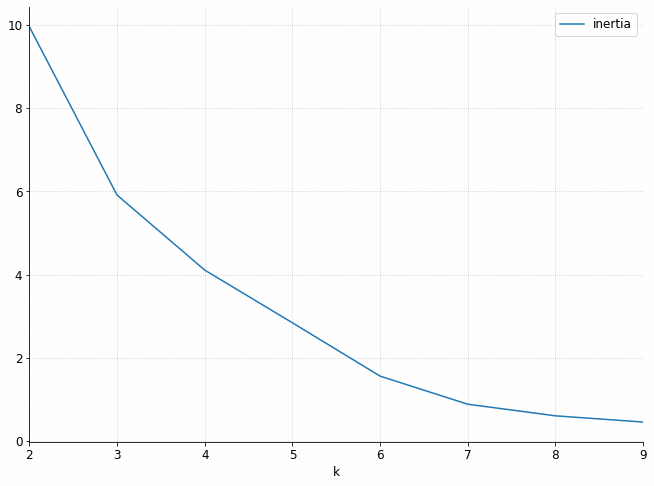

In [95]:
# Lets use the elbow method to figure out how many K to use in KMeans
# Plot inertia vs k

data = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(mx_ports)
    data.append({"k": k, "inertia":kmeans.inertia_})

pd.DataFrame(data).set_index("k").plot()

In [96]:
# For sake of time and complexity and unbalanced data, we'll move forward with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=123).fit(mx_ports)
mx_clusters = pd.Series(kmeans.predict(mx_ports), index=mx_ports.index, name="port_cluster")
mx_clusters

port_name
Andrade                0
Boquillas              0
Brownsville            0
Calexico               0
Calexico East          0
Columbus               0
Cross Border Xpress    0
Del Rio                0
Douglas                0
Eagle Pass             0
El Paso                1
Hidalgo                0
Laredo                 1
Lukeville              0
Naco                   0
Nogales                0
Otay Mesa              1
Presidio               0
Progreso               0
Rio Grande City        0
Roma                   0
San Luis               0
San Ysidro             1
Santa Teresa           0
Sasabe                 0
Tecate                 0
Tornillo-Fabens        0
Name: port_cluster, dtype: int32

In [97]:
# Set the index to port_name
mexico = mexico.set_index("port_name").join(mx_clusters).reset_index()

In [98]:
mexico

,port_name,state,port_code,border,date,crossing_method,n_crossings,port_cluster
0,Andrade,CA,2502,US-Mexico Border,2019-12-01,Pedestrians,85352,0
1,Andrade,CA,2502,US-Mexico Border,2019-12-01,Personal Vehicle Passengers,90723,0
2,Andrade,CA,2502,US-Mexico Border,2019-12-01,Personal Vehicles,47263,0
3,Andrade,CA,2502,US-Mexico Border,2019-11-01,Pedestrians,86605,0
4,Andrade,CA,2502,US-Mexico Border,2019-11-01,Personal Vehicle Passengers,90726,0
...,...,...,...,...,...,...,...,...
82283,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Trains,0,0
82284,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Train Passengers,0,0
82285,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Pedestrians,2275,0
82286,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Rail Containers Empty,0,0


TypeError: float() argument must be a string or a number, not 'Period'

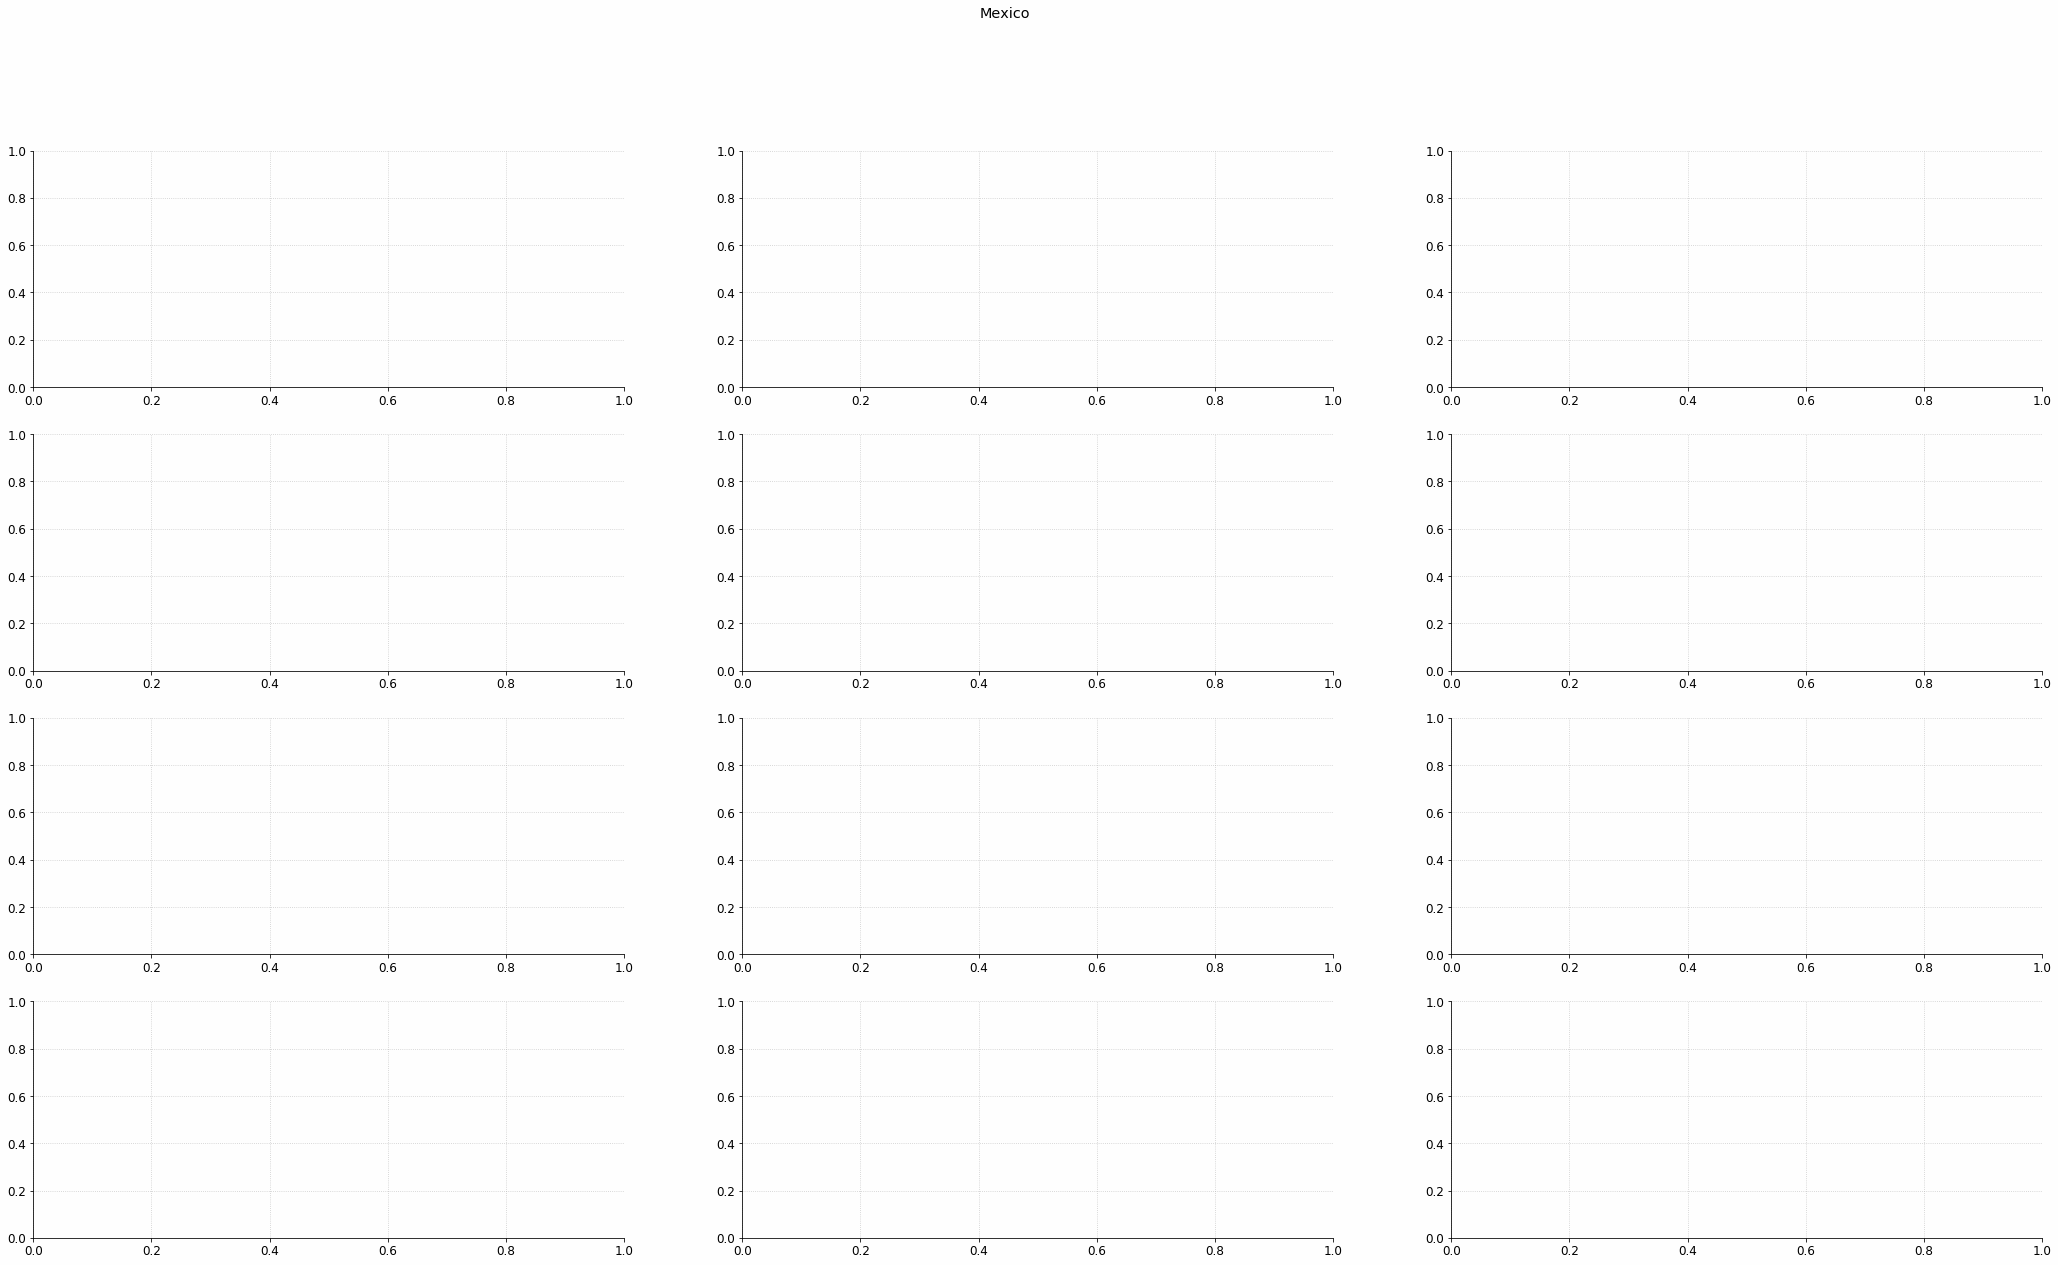

In [99]:
fig, axs = plt.subplots(4, 3, figsize=(36, 20))
fig.suptitle("Mexico")

for ax, (method, data) in zip(axs.ravel(), mexico.groupby('crossing_method')):
    data.pivot_table('n_crossings', 'date', 'port_cluster', aggfunc='sum').plot(ax=ax)
    ax.set(title=method)
    ax.get_legend().remove()

In [76]:
from fbprophet import Prophet

In [77]:
cluster0 = mexico[mexico.port_cluster==0]
cluster1 = mexico[mexico.port_cluster==1]

In [83]:
cluster0.crossing_method.value_counts()

Pedestrians                    6125
Personal Vehicle Passengers    6070
Personal Vehicles              6070
Trucks                         5912
Truck Containers Full          5908
Truck Containers Empty         5893
Bus Passengers                 5725
Buses                          5724
Trains                         5370
Rail Containers Empty          5370
Rail Containers Full           5370
Train Passengers               5293
Name: crossing_method, dtype: int64

In [102]:
mex_ts = mexico[["date", "n_crossings", "port_cluster", "crossing_method"]].rename(columns={"date":"ds", "n_crossings":"y"}).set_index("ds")

In [103]:
mex_ts

,y,port_cluster,crossing_method
ds,,,
2019-12-01,85352,0,Pedestrians
2019-12-01,90723,0,Personal Vehicle Passengers
2019-12-01,47263,0,Personal Vehicles
2019-11-01,86605,0,Pedestrians
2019-11-01,90726,0,Personal Vehicle Passengers
...,...,...,...
1996-01-01,0,0,Trains
1996-01-01,0,0,Train Passengers
1996-01-01,2275,0,Pedestrians


In [104]:
Prophet()

In [ ]:
len()